<a href="https://colab.research.google.com/github/Satyake/GANSDC/blob/main/Variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#autoencoders
import tensorflow as tf
import os
import random
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test)=fashion_mnist.load_data()
import numpy as np
import tensorflow as tf
dataset=np.concatenate([x_train, x_test], axis=0)
dataset=np.expand_dims(dataset, -1).astype('float32')/255

4422102/4422102 [==============================] - 0s 0us/step


In [2]:
from tensorflow import keras
from tensorflow.keras import layers
class SamplingLayer(layers.Layer):
  def call(self, inputs):
    zmean, zlogvar=inputs
    batch=tf.shape(zmean)[0]
    dim=tf.shape(zmean)[1]
    epsilon=tf.keras.backend.random_normal(shape=(batch, dim))
    return zmean+tf.exp(0.5*zlogvar)*epsilon


In [16]:
def encoder(latentDim, encoderInputs):
  l1=keras.models.Sequential([
      layers.Conv2D(128,3, activation='relu', strides=2, padding='same'),
      layers.Conv2D(64,3, activation='relu', strides=2, padding='same'),
      layers.Flatten(),
      layers.Dense(256, activation='relu')
  ])
  x=l1(encoderInputs)
  zmean=layers.Dense(latentDim, name='zmean')(x)
  zlogvar=layers.Dense(latentDim)(x)
  z=SamplingLayer()([zmean, zlogvar])
  return keras.Model(encoderInputs, [zmean, zlogvar, z], name='encoder')

encoderInputs=keras.Input(shape=(28,28,1))
encoder=encoder(2, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 256)                  878144    ['input_3[0][0]']             
                                                                                                  
 zmean (Dense)               (None, 2)                    514       ['sequential_2[0][0]']        
                                                                                                  
 dense_4 (Dense)             (None, 2)                    514       ['sequential_2[0][0]']        
                                                                                            

In [17]:
def  decoder(latentInputs):
  l1=keras.models.Sequential([
      layers.Dense(7*7*64, activation='relu', input_shape=(latentInputs.shape[1],)),
      layers.Reshape((7,7,64)),
      layers.Conv2DTranspose(128,3,activation='relu', strides=2, padding='same'),
      layers.Conv2DTranspose(64,3, activation='relu', strides=2, padding='same'),
      layers.Conv2DTranspose(1,3, activation='sigmoid', padding='same')

  ])
  return keras.Model(latentInputs, l1(latentInputs), name='decoder')
latentInputs=keras.Input(shape=(2,))
decoder=decoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_3 (Sequential)   (None, 28, 28, 1)         157633    
                                                                 
Total params: 157633 (615.75 KB)
Trainable params: 157633 (615.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
def reconstructionloss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstructed), axis=(1,2)
      )
  )
def kldivergence(zmean, zlogvar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5* (1+zlogvar-tf.square(zmean)-tf.exp(zlogvar)),
          axis=1
      )
  )
def caltotalloss(data, reconstructed, zmean, zlogvar):
  loss1=reconstructionloss(data, reconstructed)
  loss2=kldivergence(zmean, zlogvar)
  klweight=3.0
  return loss1, loss2, loss1+klweight+loss2

In [19]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder,**kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder=encoder
    self.decoder=decoder
    self.totallosstracker=keras.metrics.Mean(name='total loss')
    self.celosstracker=keras.metrics.Mean(name='ce loss')
    self.kllosstracker=keras.metrics.Mean(name='kl loss')
  @property
  def metrics(self):
    return [
        self.totallosstracker,
        self.celosstracker,
        self.kllosstracker
    ]

  def train_step(self, data):

    with tf.GradientTape() as tape:
      zmean, zlogvar, z=self.encoder(data)
      reconstruction=self.decoder(z)
      celoss, klloss, totalloss=caltotalloss(data, reconstruction, zmean, zlogvar)

    grads=tape.gradient(totalloss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.totallosstracker.update_state(totalloss)
    self.celosstracker.update_state(celoss)
    self.kllosstracker.update_state(klloss)

    return {
        "total_loss": self.totallosstracker.result(),
        'ce_loss': self.celosstracker.result(),
        'kl_loss': self.kllosstracker.result()
    }




In [20]:
vae=VAE(encoder, decoder)
vae.compile(optimizer='adam')


In [21]:
history=vae.fit(dataset, epochs=32, batch_size=128)

Epoch 1/32
547/547 [==============================] - 264s 479ms/step - total_loss: 350.5865 - ce_loss: 342.8496 - kl_loss: 4.7368
Epoch 2/32
547/547 [==============================] - 266s 486ms/step - total_loss: 274.9474 - ce_loss: 266.0451 - kl_loss: 5.9021
Epoch 3/32
547/547 [==============================] - 258s 471ms/step - total_loss: 269.7450 - ce_loss: 260.6800 - kl_loss: 6.0649
Epoch 4/32
547/547 [==============================] - 272s 498ms/step - total_loss: 267.6740 - ce_loss: 258.5288 - kl_loss: 6.1452
Epoch 5/32
547/547 [==============================] - 278s 508ms/step - total_loss: 266.3043 - ce_loss: 257.1052 - kl_loss: 6.1991
Epoch 6/32
547/547 [==============================] - 257s 469ms/step - total_loss: 265.3382 - ce_loss: 256.0945 - kl_loss: 6.2438
Epoch 7/32
547/547 [==============================] - 266s 486ms/step - total_loss: 264.4569 - ce_loss: 255.1645 - kl_loss: 6.2924
Epoch 8/32
547/547 [==============================] - 261s 477ms/step - total_loss:

1/1 [==============================] - 0s 215ms/step


TypeError: Image data of dtype object cannot be converted to float

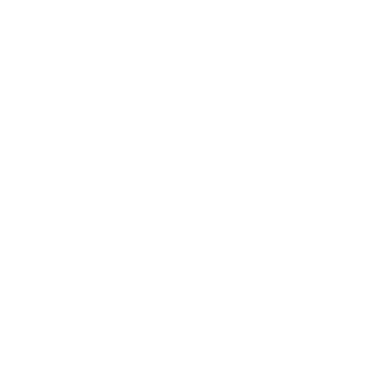

In [22]:
import matplotlib.pyplot as plt
synth=vae.decoder.predict([[1,2]]) #prob dist of 1 and 2  u =1 sd =2
plt.axis('off')
plt.imshow(synth.reshape)

In [14]:
!pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 855.9 kB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [1]:
import tensorflow as tf


In [2]:
encoding_dim=32

In [94]:
input_img=tf.keras.layers.Input(shape=(784,))
encoded=tf.keras.layers.Dense(encoding_dim, activation='relu')(input_img)
decoded=tf.keras.layers.Dense(784, activation='sigmoid')(encoded)
autoencoder=tf.keras.Model(inputs=input_img, outputs=decoded)

In [95]:
#seperate encoder
encoder=tf.keras.Model(input_img, encoded)

In [96]:
#seperate decoder
encoder_input=tf.keras.layers.Input(shape=(encoding_dim,))
decoder_layer=autoencoder.layers[-1]
decoder=tf.keras.Model(encoder_input, decoder_layer(encoder_input))

In [97]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [98]:
from keras.datasets import mnist
import numpy as np
(x_train,_),(x_test,_)=mnist.load_data()

In [99]:
x_train=x_train.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0
#x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
#x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train.shape

(60000, 28, 28)

In [100]:
x_test=x_test.reshape(len(x_test),784)

In [101]:
x_train=x_train.reshape(len(x_train),784)

In [102]:
x_test.shape

(10000, 784)

In [103]:
#x_train=np.expand_dims(x_train,axis=-)

In [104]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [38]:
x_test=np.expand_dims(x_train,axis=-1)

In [105]:
autoencoder.fit(x_train,x_train,
                epochs=50, batch_size=200,shuffle=True, validation_data=(x_test, x_test))

Epoch 1/50
300/300 [==============================] - 3s 9ms/step - loss: 0.2605 - val_loss: 0.1808
Epoch 2/50
300/300 [==============================] - 3s 9ms/step - loss: 0.1604 - val_loss: 0.1425
Epoch 3/50
300/300 [==============================] - 5s 16ms/step - loss: 0.1337 - val_loss: 0.1240
Epoch 4/50
300/300 [==============================] - 5s 15ms/step - loss: 0.1197 - val_loss: 0.1132
Epoch 5/50
300/300 [==============================] - 3s 9ms/step - loss: 0.1112 - val_loss: 0.1067
Epoch 6/50
300/300 [==============================] - 3s 9ms/step - loss: 0.1053 - val_loss: 0.1016
Epoch 7/50
300/300 [==============================] - 3s 11ms/step - loss: 0.1012 - val_loss: 0.0982
Epoch 8/50
300/300 [==============================] - 3s 11ms/step - loss: 0.0983 - val_loss: 0.0960
Epoch 9/50
300/300 [==============================] - 2s 8ms/step - loss: 0.0966 - val_loss: 0.0947
Epoch 10/50
300/300 [==============================] - 3s 9ms/step - loss: 0.0955 - val_loss: 0.

In [55]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

In [56]:
x_train.shape

(60000, 784)

In [120]:
#convolutional autoencoder

input_img=tf.keras.layers.Input(shape=(28,28,1))
x=tf.keras.layers.Conv2D(16,(3,3), activation='relu',padding='same')(input_img)
x=tf.keras.layers.Conv2D(8,(3,3), padding='same')(x)
encoded=tf.keras.layers.Conv2D(8,(3,3), padding='same')(x)

#decoder
x=tf.keras.layers.Conv2D(8,(3,3), activation='relu', padding='same')(encoded)
x=tf.keras.layers.Conv2D(8,(3,3), activation='relu', padding='same')(x)
decoded=tf.keras.layers.Conv2D(16,(3,3), padding='same',activation='relu')(x)
autoencoder=tf.keras.Model(input_img, decoded)

In [121]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [122]:
autoencoder.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 8)         1160      
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 8)         584       
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 8)         584       
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 8)         584       
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 16)        116

In [123]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [124]:
x_train.shape

(60000, 28, 28, 1)

In [125]:
autoencoder.fit(x_train,x_train, epochs=50, validation_data=(x_test, x_test))

1875/1875 [==============================] - 168s 89ms/step - loss: 0.0590 - val_loss: 0.0585
Epoch 48/50
1875/1875 [==============================] - 160s 85ms/step - loss: 0.0590 - val_loss: 0.0582
Epoch 49/50
1875/1875 [==============================] - 162s 86ms/step - loss: 0.0589 - val_loss: 0.0581
Epoch 50/50
1875/1875 [==============================] - 157s 84ms/step - loss: 0.0590 - val_loss: 0.0584


313/313 [==============================] - 9s 28ms/step


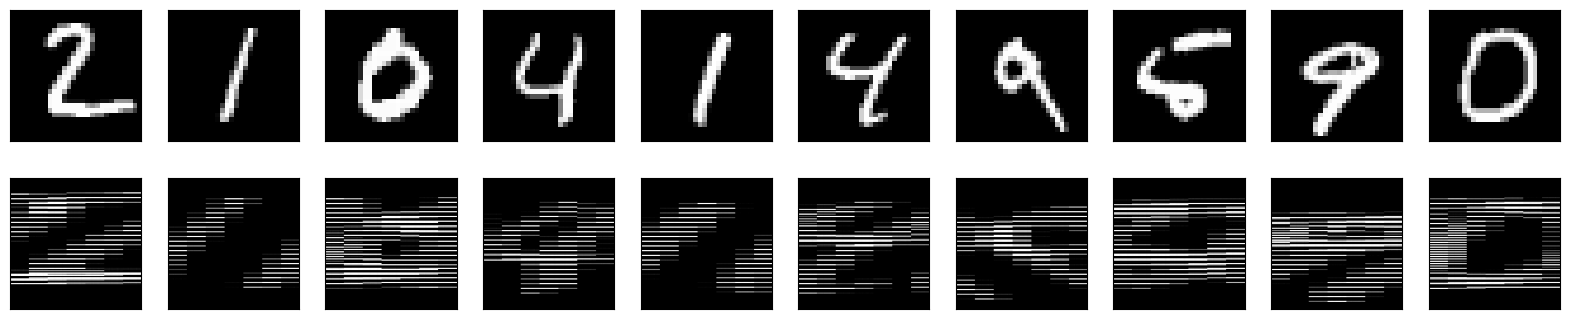

In [128]:
decoded_imgs = autoencoder.predict(x_test)
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(112, 112))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
